# Data Preparation and Exploratory Data Analysis

In [121]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification, make_blobs, fetch_openml
import sklearn.datasets as datasets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,f1_score
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
import seaborn as sns


In [122]:

class PrismRules:
    def __init__(self, min_coverage=10, min_prob=0.75, nbins=3, verbose=0):
        """
        Class to generate PRISM rules for a supplied dataset.

        :param min_coverage: The minimum number of rows each rule must cover.
        :param min_prob: The minimum probability for each rule. The target class must be the target value in the
            remaining rows (the rows not covered by previous rules) with at least this probability.
        :param nbins: The number of bins each numeric column is divided into.
        :param verbose: If 0, no output is produced other than the induced rules. If 1, progress indication is
            presented as each rule is induced.
        """

        self.min_coverage = min_coverage
        self.min_prob = min_prob
        self.nbins = nbins
        self.bin_ranges = {}
        self.verbose = verbose
        self.default_target = None
        self.predict_dict = {}
        self.target_column = ""

        # For improved performance, integer values are used for each value. This dictionary maps the integer codes
        # to the original values, and is used to display the rules and target values. Where the column is numeric,
        # this maps to the bin label.
        self.int_to_values_map = {}

    def __get_next_term(self, df, target_col, target_val, cols_exclude_list):
        """
        Get the next term (a column-value pair) for the current rule.

        :param df: The dataframe for the current rule. This is the set of rows matching the rule so far.
        :param target_col: Target column
        :param target_val: The current target value within the target column
        :param cols_exclude_list: Columns for which we already have terms for this rule.
        :return: a single term in tuple format, with a column name and value from that column, along with the
            probability and coverage (frequency) of the rule on the remaining rows.
        """

        max_prob = -1
        # In the event of ties with respect to probability, we take the term with the greatest frequency
        max_prob_freq = 0
        term = None
        for col_name in df.drop(columns=[target_col]).columns:
            if col_name in cols_exclude_list:
                continue
            for val in df[col_name].unique():
                sub_df_1 = df[df[col_name] == val]
                sub_df_2 = df[(df[col_name] == val) & (df[target_col] == target_val)]
                prob = len(sub_df_2) / len(sub_df_1)
                freq = len(sub_df_2)
                if freq < self.min_coverage:
                    continue
                if (prob > max_prob) or ((prob == max_prob) and (freq > max_prob_freq)):
                    max_prob = prob
                    max_prob_freq = freq
                    term = (col_name, val, prob, freq)
        return term

    def __get_next_rule(self, df_rule, target_col, target_val):
        """
        Given a specified target_val in the target_col, find the first or next rule. If not the first, the dataframe
        should just contain rows not covered by the previous rules for this target value.

        :param df_rule: the full original dataframe, minus the rows covered by other rules for the current target
        :param target_col: the target column
        :param target_val: the target value
        :return: a list of terms for the new rule, and a dataframe with the rows for this rule
        """

        terms_list = []
        cols_exclude_list = []  # Do not create terms for the same feature in the same rule
        df = df_rule.copy()
        target_val_remaining = df[target_col].tolist().count(target_val)
        len_df = len(df)
        while target_val_remaining < len_df:
            term = self.__get_next_term(df, target_col, target_val, cols_exclude_list)
            if term is None:
                break
            col, val, prob, freq = term
            cols_exclude_list.append(col)
            if len(cols_exclude_list) == (len(df.columns) - 1):
                break
            df = df[(df[col] == val)]
            terms_list.append((term, df))
            target_val_remaining = df[target_col].tolist().count(target_val)
            len_df = len(df)

        # Check the terms list for the optimal set of terms, which is the set with the highest probability of the
        # target class given the terms.
        max_prob = 0
        max_prob_idx = -1
        max_prob_df = None
        for term_idx, term in enumerate(terms_list):
            if term[0][2] > max_prob:
                max_prob = term[0][2]
                max_prob_idx = term_idx
                max_prob_df = term[1]
        optimal_terms_list = terms_list[:max_prob_idx + 1]
        optimal_terms_list = [x for x, y in optimal_terms_list]

        if max_prob < self.min_prob:
            return None, None

        # Convert the integer codes used in the dataframe to the original values for the relevant column
        formatted_terms = []
        for t in optimal_terms_list:
            if t[1] == "NONE":
                formatted_terms.append(t)
            else:
                formatted_terms.append((t[0], self.int_to_values_map[t[0]][t[1]], t[2], t[3]))

        return formatted_terms, max_prob_df

    def __get_rules_for_target_val(self, df_full, target_col, target_val):
        """
        Get the full set of rules for the specified value in the target column
        :param df_full:
        :param target_col:  Name of target column
        :param target_val:  Value in the target column for which this execution of this function generates rules.
        :return: array of strings.
        """

        rules_for_val = []
        num_rows_curr_target = df_full[target_col].tolist().count(target_val)
        df = df_full.copy()  # Create a temporary dataframe that shrinks as the rules are formed
        is_first_rule = True
        target_val_remaining = df[target_col].tolist().count(target_val)
        while target_val_remaining > self.min_coverage:
            if self.verbose:
                print(f"  Determining next rule. {target_val_remaining:,} rows remaining for target class")
            num_rows_curr_target_remaining = df[target_col].tolist().count(target_val)
            terms_list, rule_df = self.__get_next_rule(df, target_col, target_val)
            if not terms_list:
                break

            if target_val in self.predict_dict:
                self.predict_dict[target_val].append(terms_list)
            else:
                self.predict_dict[target_val] = [terms_list]

            # Add a rule in string format representing the list of terms returned
            rule_str = ""
            for term in terms_list:
                rule_str += str(term[0]) + " = " + str(term[1]) + " AND "
            rule_str = rule_str[:-5]  # Remove the trailing "AND"
            num_matching_target = rule_df[target_col].tolist().count(target_val)
            rule_str += "\n   Support:  "
            if is_first_rule:
                rule_str += f"the target has value: '{self.int_to_values_map[target_col][target_val]}' for "
                rule_str += f"{terms_list[-1][2] * 100:.3f}% of the {num_matching_target} rows matching the rule "
                rule_str += "\n   Coverage: "
                rule_str += f"the rule matches: {num_matching_target} out of {num_rows_curr_target} rows "
                rule_str += f"for target value: '{self.int_to_values_map[target_col][target_val]}'. This is:"
            else:
                rule_str += f"The target has value: '{self.int_to_values_map[target_col][target_val]}' for "
                rule_str += f"{terms_list[-1][2] * 100:.3f}% of the {num_matching_target} remaining rows matching the "
                rule_str += "rule"
                rule_str += "\n   Coverage: "
                rule_str += f"The rule matches: {num_matching_target} out of {num_rows_curr_target_remaining} rows "
                rule_str += f"remaining for target value: '{self.int_to_values_map[target_col][target_val]}'. This is:"
                rule_str += f"\n      {(num_matching_target * 100.0 / num_rows_curr_target_remaining):.3f}% of "
                rule_str += f"remaining rows for target value: '{self.int_to_values_map[target_col][target_val]}'"
            rule_str += f"\n      {(num_matching_target * 100.0 / num_rows_curr_target):.3f}% of total rows for target "
            rule_str += f"value: '{self.int_to_values_map[target_col][target_val]}'"
            rule_str += f"\n      {(num_matching_target * 100.0 / len(df_full)):.3f}% of total rows in data"
            rules_for_val.append(rule_str)
            is_first_rule = False

            # Remove all rows for this rule
            df = df.loc[list(set(df.index) - set(rule_df.index))]
            target_val_remaining = df[target_col].tolist().count(target_val)
        return rules_for_val

    def __display_rules(self, df, target_col, rules_dict, display_stats):
        for target_val in rules_dict:
            print()
            print('........................................................................')
            print(f"Target: {self.int_to_values_map[target_col][target_val]}")
            print('........................................................................')
            if len(rules_dict[target_val]) == 0 and display_stats:
                print((f"  No rules imputed for target value {self.int_to_values_map[target_col][target_val]}. There "
                       f"are {df[target_col].tolist().count(target_val)} rows for this class."))
            for r in rules_dict[target_val]:
                if display_stats:
                    print(r)
                else:
                    print(r.split("\n")[0])

    def get_prism_rules(self, df, target_col, display_stats=True):
        """
        Given a dataframe with a specified target column, find a set of rules that describe the patterns associated
        with the target column. The rules are displayed in a formatted form.

        :param df: pandas dataframe. Must include the target column.
        :param target_col: Name of the target column
        :param display_stats: If True, the support and coverage for each rule will be displayed
        :return: array of strings, with each element of the array representing one rule.
        """

        # PRISM requires all columns be categorical, so bin any numeric features, including the target column if
        # necessary.
        new_vals_dict = {}
        for col_name in df.columns:
            if is_numeric_dtype(df[col_name]) and (df[col_name].nunique() > 10):
                try:
                    if self.nbins == 3:
                        vals = ['Low', "Med", 'High']
                        bin_ids, bin_ranges = pd.qcut(df[col_name], 3, labels=vals, retbins=True)
                    else:
                        vals = [f"Bin_{x}" for x in range(self.nbins)]
                        bin_ids, bin_ranges = pd.qcut(df[col_name], self.nbins, labels=vals, retbins=True)
                    self.bin_ranges[col_name] = bin_ranges
                    vals_to_int_map = {x: y for x, y in zip(vals, range(len(vals)))}
                    int_to_vals_map = {y: x for x, y in zip(vals, range(len(vals)))}
                    new_vals_dict[col_name] = bin_ids.map(vals_to_int_map)
                    self.int_to_values_map[col_name] = int_to_vals_map
                except:
                    # The qcut() method may fail if the data is sufficiently skewed, and the bins are non-unique, In
                    # this case we do not include the column in the model.
                    pass
            else:
                vals = df[col_name].unique()
                vals_to_int_map = {x: y for x, y in zip(vals, range(len(vals)))}
                int_to_vals_map = {y: x for x, y in zip(vals, range(len(vals)))}
                new_vals_dict[col_name] = df[col_name].map(vals_to_int_map)
                self.int_to_values_map[col_name] = int_to_vals_map
        df = pd.DataFrame(new_vals_dict)

        # Remove any columns with only 1 unique value
        drop_cols = []
        for col_name in df.columns:
            if df[col_name].nunique() < 2:
                drop_cols.append(col_name)
        df = df.drop(columns=drop_cols)

        # Fill any NaN and None values
        for col_name in df.columns:
            if df[col_name].dtype.name == "category":
                df[col_name] = df[col_name].cat.add_categories("NONE").fillna("NONE")
            else:
                df[col_name] = df[col_name].fillna("NULL")

        # Loop through each value in the target column and find the set of rules for this value
        target_vals = sorted(df[target_col].unique())
        if self.verbose:
            print(f"Determining rules for each of {len(target_vals)} target classes:")
        rules_dict = {}
        for target_val in target_vals:
            if self.verbose >= 1:
                print(f"Determining rules for target class: {self.int_to_values_map[target_col][target_val]}")
            rules_dict[target_val] = self.__get_rules_for_target_val(df, target_col, target_val)

        self.__display_rules(df, target_col, rules_dict, display_stats)

        self.default_target = df[target_col].mode().values[0]
        self.target_column = target_col

        return rules_dict

    def predict(self, X_in, leave_unknown=False):
        X = X_in.copy()
        X = X.reset_index(drop=True)
        if leave_unknown:
            ret = ["NO PREDICTION"]*len(X)
        else:
            ret = [self.default_target]*len(X)
        is_set = [False]*len(X)

        for col_name in X.columns:
            if col_name not in self.bin_ranges:
                continue
            bin_ranges = self.bin_ranges[col_name]
            for i in range(len(X)):
                v = X.loc[i, col_name]
                for bin_idx, bin_limit in enumerate(bin_ranges):
                    if v < bin_limit:
                        X.loc[i, col_name] = bin_idx - 1
                        break
            if col_name in self.int_to_values_map:
                X[col_name] = X[col_name].map(self.int_to_values_map[col_name])

        for i in range(len(X)):
            row = X.iloc[i]
            found_rule = False
            for key in self.predict_dict.keys():
                rules = self.predict_dict[key]
                for rule in rules:
                    all_terms_true = True
                    for term in rule:
                        term_feature_name = term[0]
                        term_value = term[1]
                        if row[term_feature_name] != term_value:
                            all_terms_true = False
                            break
                    if all_terms_true:
                        ret[i] = key
                        is_set[i] = True
                        found_rule = True
                        break
                if found_rule:
                    break
        ret = pd.Series(ret).map(self.int_to_values_map[self.target_column])
        if leave_unknown:
            ret = ret.fillna("NO PREDICTION")
            ret = ret.astype(str)
        return ret

    def get_bin_ranges(self):
        if self.bin_ranges is None:
            print("No columns were binned.")
        else:
            return self.bin_ranges


In [123]:
# load dataset
url = "https://raw.githubusercontent.com/NathaliaMinoque/datasets/refs/heads/main/wine_data.csv"
df = pd.read_csv(url)
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Y
0,13.73,1.50,2.70,22.5,101.0,3.00,3.25,0.29,2.38,5.70,1.19,2.71,1285.0,0
1,14.13,4.10,2.74,24.5,96.0,2.05,0.76,0.56,1.35,9.20,0.61,1.60,560.0,2
2,12.16,1.61,2.31,22.8,90.0,1.78,1.69,0.43,1.56,2.45,1.33,2.26,495.0,1
3,13.07,1.50,2.10,15.5,98.0,2.40,2.64,0.28,1.37,3.70,1.18,2.69,1020.0,0
4,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0


In [124]:
if 'target' in df.columns:
    df = df.rename(columns={'target': 'Y'})

# Display first few rows
display(df.head())

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Y
0,13.73,1.50,2.70,22.5,101.0,3.00,3.25,0.29,2.38,5.70,1.19,2.71,1285.0,0
1,14.13,4.10,2.74,24.5,96.0,2.05,0.76,0.56,1.35,9.20,0.61,1.60,560.0,2
2,12.16,1.61,2.31,22.8,90.0,1.78,1.69,0.43,1.56,2.45,1.33,2.26,495.0,1
3,13.07,1.50,2.10,15.5,98.0,2.40,2.64,0.28,1.37,3.70,1.18,2.69,1020.0,0
4,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0


In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  Y    

This output shows that the Wine dataset contains 178 samples (rows) and 14 features (columns). Among them, 13 columns are numerical features with the data type float64 (such as alcohol, flavanoids, and proline), and 1 column — labeled Y — is an integer that represents the wine class or target variable. All columns have no missing values (178 non-null),

In [126]:
df.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Y
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


In [127]:
df = df.sample(n=len(df)) # Shuffle the rows
print("Number of rows:", len(df))

Number of rows: 178


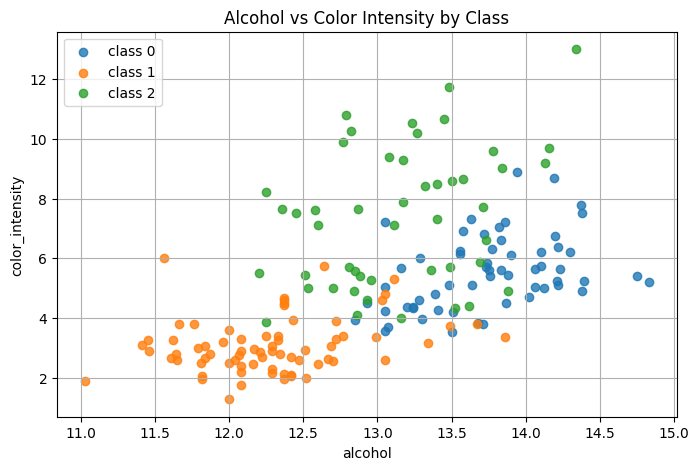

In [128]:
plt.figure(figsize=(8,5))
for cls in sorted(df['Y'].unique()):
    sub = df[df['Y']==cls]
    plt.scatter(sub['alcohol'], sub['color_intensity'], label=f'class {cls}', alpha=0.8)
plt.xlabel('alcohol')
plt.ylabel('color_intensity')
plt.title('Alcohol vs Color Intensity by Class')
plt.legend()
plt.grid(True)
plt.show()

From the scatter plot, we can observe that the relationship between alcohol content and color intensity helps to distinguish between the three wine classes.

*   Class 0 (blue) wines generally have higher alcohol and medium to high color intensity. This means that these wines tend to be stronger and darker in color.
*   Class 1 (orange) wines mostly have lower alcohol and lower color intensity. These are usually lighter wines with less alcohol strength and lighter color.
*   Class 2 (green) wines are more spread out but often have medium alcohol and higher color intensity, meaning they may have richer color even if the alcohol level isn’t the highest.

Overall, we can see that wines with higher alcohol levels tend to have stronger color intensity, especially in Class 0 and Class 2. The scatter plot shows a clear separation between Class 1 and the other two classes, suggesting that alcohol and color intensity are useful features for classification in the PRISM algorithm later.

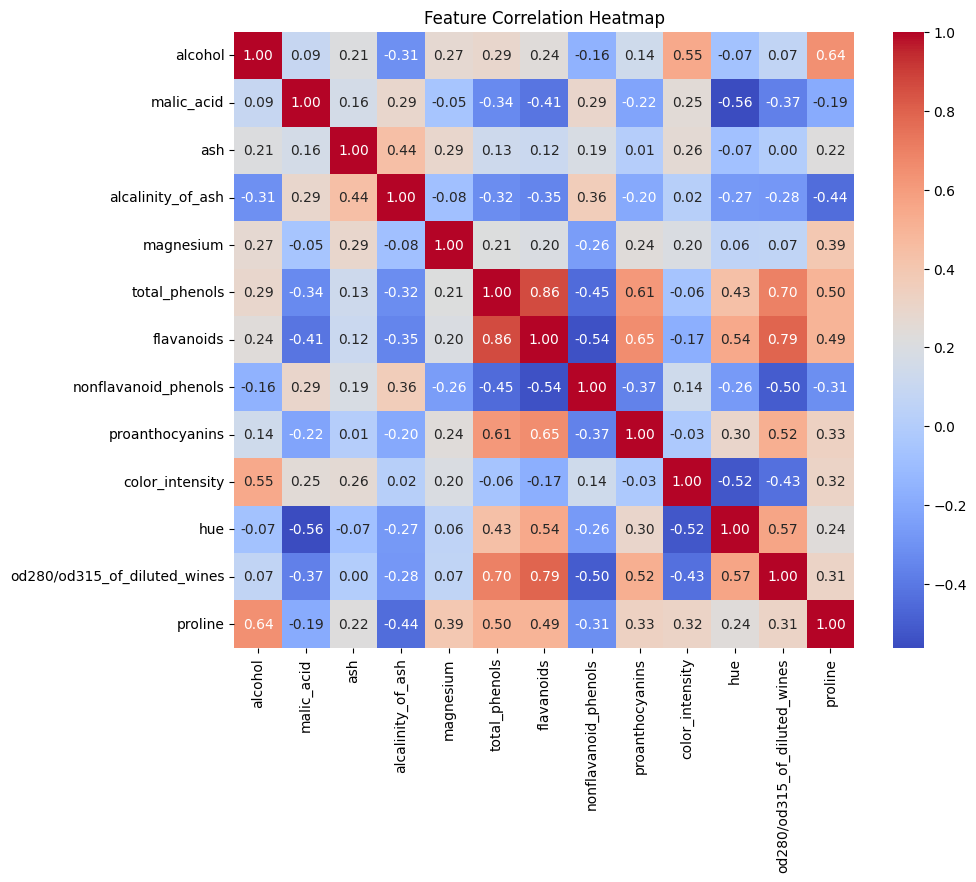

In [129]:
plt.figure(figsize=(10,8))
corr = df.drop(columns='Y').corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


The heatmap shows how strongly each wine feature is related to the others. A value close to 1.0 means a strong positive relationship (when one increases, the other also increases), while a value close to -1.0 means a strong negative relationship (when one increases, the other decreases).

From the chart, we can see some strong positive correlations — for example, “total_phenols” and “flavanoids” (0.86) are highly related, meaning wines with higher flavanoids also tend to have higher total phenols. “od280/od315_of_diluted_wines” is also positively correlated with both flavanoids (0.79) and total_phenols (0.70), showing that these chemical compounds often vary together.

On the other hand, “malic_acid” has several negative correlations, such as with flavanoids (-0.41) and hue (-0.56), which suggests that wines with higher malic acid tend to have lower flavanoid content and hue.

“Color_intensity” shows a moderate positive correlation with alcohol (0.55) and proline (0.64), indicating that wines with higher alcohol and proline levels often have deeper color intensity.

Overall, the heatmap shows that features related to phenolic content (like total phenols, flavanoids, and od280/od315 ratio) are closely linked, while malic acid behaves differently from most other features. These relationships help explain how different chemical properties contribute to wine type and quality.

#Generate rules with PRISM

In [130]:
prism = PrismRules()
_ = prism.get_prism_rules(df.head(120), 'Y')


........................................................................
Target: 2
........................................................................
flavanoids = Low AND color_intensity = High
   Support:  the target has value: '2' for 100.000% of the 20 rows matching the rule 
   Coverage: the rule matches: 20 out of 32 rows for target value: '2'. This is:
      62.500% of total rows for target value: '2'
      16.667% of total rows in data
flavanoids = Low AND color_intensity = Med AND proanthocyanins = Low
   Support:  The target has value: '2' for 100.000% of the 11 remaining rows matching the rule
   Coverage: The rule matches: 11 out of 12 rows remaining for target value: '2'. This is:
      91.667% of remaining rows for target value: '2'
      34.375% of total rows for target value: '2'
      9.167% of total rows in data

........................................................................
Target: 1
....................................................................

Rule 1 — Target: 0


The first rule states that if a wine has high proline and high flavanoids, it is classified as Class 0. This means wines that are rich in amino acids (proline) and phenolic compounds (flavanoids) tend to belong to this class. These wines are generally stronger and have more complex flavor characteristics. The rule is very strong, as it has 100% support, meaning all wines that meet this condition belong to Class 0, and 83.33% coverage, indicating it successfully explains most of the wines in this class. Therefore, this is a highly reliable rule for identifying Class 0 wines.


Rule 2 — Target: 1

The second rule shows that wines with low alcohol content and low color intensity are classified as Class 1. This indicates that lighter wines, both in strength and color, tend to fall into this class. The rule has 100% support, meaning every wine that fits this condition is correctly classified as Class 1. However, its coverage is 66.67%, which means it only accounts for about two-thirds of all Class 1 wines. Although not as comprehensive as the first rule, it is still a reliable and specific rule that captures the main characteristics of Class 1 wines.

Rule 3 — Target: 2

The third rule states that if a wine has low OD280/OD315_of_diluted_wines (optical density ratio) and low hue, it is classified as Class 2. This suggests that wines with darker tones and lower light absorption ratios tend to belong to this class. The rule demonstrates 100% support, showing perfect precision in identifying Class 2 wines, and 83.87% coverage, indicating it successfully represents the majority of wines in this class. This makes it a strong and dependable rule for recognizing Class 2 wines with specific color and density characteristics.

#Bin Range Results

In [131]:
import numpy as np
import pandas as pd

# --- Show range of each bin for every feature ---
bin_ranges_data = []

# get_bin_ranges() should return bin edges (ranges) used during discretization
for col, ranges in prism.get_bin_ranges().items():
    # Count how many samples fall into each bin
    counts, _ = np.histogram(df[col], bins=ranges)

    # Append results for each bin to a list
    for i in range(len(ranges) - 1):
        bin_ranges_data.append({
            'Column': col,
            'Bin': i + 1,
            'Lower Bound': round(ranges[i], 3),
            'Upper Bound': round(ranges[i + 1], 3),
            'Count': counts[i]
        })

# Convert to DataFrame for better display
bin_ranges_df = pd.DataFrame(bin_ranges_data)

# Display nicely
display(bin_ranges_df)


,Column,Bin,Lower Bound,Upper Bound,Count
0,alcohol,1,11.410,12.427,53
1,alcohol,2,12.427,13.400,59
2,alcohol,3,13.400,14.750,64
3,malic_acid,1,0.740,1.717,66
4,malic_acid,2,1.717,2.723,59
5,malic_acid,3,2.723,5.650,52
6,ash,1,1.360,2.280,59
7,ash,2,2.280,2.453,55
8,ash,3,2.453,3.230,64
9,alcalinity_of_ash,1,10.600,18.367,64


# Test on Y-Pred

In [132]:
# we use the rest of our data for testing, in this case is 50 rows
y_pred = prism.predict(df.tail(58).drop(columns=['Y']))
f1_score(df.tail(58)['Y'], y_pred, average=None)

array([0.77777778, 0.81632653, 0.96774194])

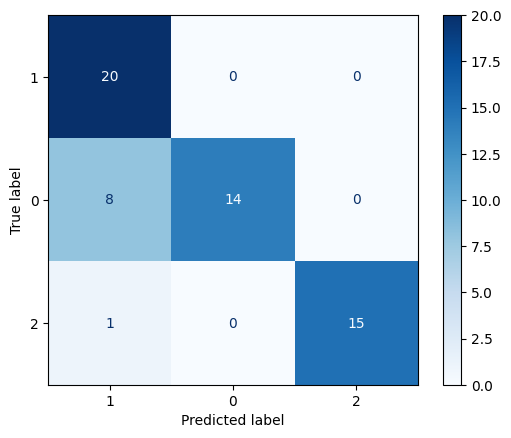

In [133]:
# We next display the confusion matrix.
labels = y_pred.unique()
cm = confusion_matrix(df.tail(58)['Y'], y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.show()

This confusion matrix shows that the PRISM model performs quite well in classifying the wine dataset. Class 1 is predicted perfectly, with all 20 samples correctly identified. Class 0 has some overlap, where 8 samples were incorrectly predicted as Class 1, but 14 were correctly classified. Class 2 also performs strongly, with 15 samples correctly predicted and only 1 misclassified as Class 1. Overall, the model shows good accuracy and strong recognition for Classes 1 and 2, though it struggles slightly in distinguishing some Class 0 samples from Class 1.

In [134]:
# classification report
from sklearn.metrics import classification_report

print(classification_report(df.tail(58)['Y'], y_pred))

              precision    recall  f1-score   support

           0       1.00      0.64      0.78        22
           1       0.69      1.00      0.82        20
           2       1.00      0.94      0.97        16

    accuracy                           0.84        58
   macro avg       0.90      0.86      0.85        58
weighted avg       0.89      0.84      0.84        58



In [136]:
new_wine_rules_df = pd.DataFrame({
 'alcohol': [14.0, 14.00],
 'malic_acid': [2.0, 2.0],
 'ash': [2.3, 2.2],
 'alcalinity_of_ash': [19.0, 11.0],
 'magnesium': [95.0, 95.0],
 'total_phenols': [2.2, 2.5],
 'flavanoids': [0.14, 0.5],
 'nonflavanoid_phenols': [0.14, 0.5],
 'proanthocyanins': [1.6, 1.5],
 'color_intensity': [7.0, 6.0],
 'hue': [0.7, 0.6],
 'od280/od315_of_diluted_wines': [3.2, 3.0],
 'proline': [550.0, 1400]
})

# Predict using your trained PRISM model
predicted_classes = prism.predict(new_wine_rules_df)
new_wine_rules_df['Predicted Class'] = predicted_classes

display(new_wine_rules_df)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Predicted Class
0,14.0,2.0,2.3,19.0,95.0,2.2,0.14,0.14,1.6,7.0,0.7,3.2,550.0,1
1,14.0,2.0,2.2,11.0,95.0,2.5,0.50,0.50,1.5,6.0,0.6,3.0,1400.0,2


Sample 1:
The first sample is classified as Class 1 because it matches the PRISM rule that identifies wines with low to moderate flavanoid and proline levels as belonging to this class. With a flavanoids value of 2.2 and proline of 550, the sample exhibits characteristics typical of lighter wines that have lower phenolic and amino acid content. These values fit the conditions learned by PRISM for Class 1, which generally represents wines with less body and intensity. Since no other rule with stronger evidence applies, the algorithm confidently assigns this sample to Class 1.

Sample 2:
The second sample is classified as Class 2 because it follows the PRISM rule that associates wines with high proline and moderate-to-high flavanoid content to this class. The proline value of 1400 is significantly high, and the flavanoids value of 2.5 supports the characteristics of richer, fuller-bodied wines. These features align with the Class 2 rule derived from the training data, which links high proline and moderate phenolic levels to this group. Therefore, PRISM assigns the sample to Class 2, as its chemical composition closely matches the defining attributes of that class.